<a href="https://colab.research.google.com/github/Henkin2th/AIPI-590.05-Assignement/blob/main/AIPI590_Explainable_Techniques_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
!pip install shap

  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /tmp/pip-install-yx5qhnuc/alepython_85faae26a8074bebb979a9afac8c02f7
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-install-yx5qhnuc/alepython_85faae26a8074bebb979a9afac8c02f7
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 1.6 MB/s eta 0:00:00
  Created wheel for alepython: filename=alepython-0.1.dev17+g286350a-py3-none-any.whl size=15139 sha256=d4da956c5061c29247f4c8f043b6afa3bf7190edc750c6377b26f890f84d60da
  Stored in directory: /tmp/pip-ephem-wheel-cache-l5clo6ns/wheels/80/2e/91/7f216caef9a7f0c6ce18ee562b6156df43b3a79f69a0c1f3d1
Successfully built alepython


# **Explainable AI Techniques Using  Diabetes Dataset**
1. Dataset Selection and Exploratory Analysis
We will use the Diabetes dataset to analyze how  the feature bmi (Body Mass Index) affects the prediction of disease progression using various explanation techniques.

**Importing Libraries and Loading the Dataset**

In [4]:
# Data and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Models
import xgboost as xgb
from sklearn.model_selection import train_test_split

# XAI (Explainability AI) libraries
import shap
from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay, permutation_importance


# Load the Diabetes dataset from sklearn
from sklearn.datasets import load_diabetes

In [5]:

# Load the Diabetes dataset
diabetes = load_diabetes()
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = diabetes.target

# Model Training
We use an XGBoost Regressor model to predict the target variable (disease progression).

In [6]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Train an XGBoost Regressor model
model = xgb.XGBRegressor().fit(X_train, y_train)

# Generating Partial Dependence Plots (PDP)
PDP shows the average marginal effect of bmi on the predicted disease progression. This gives a global view of the effect of bmi across all instances in the dataset.

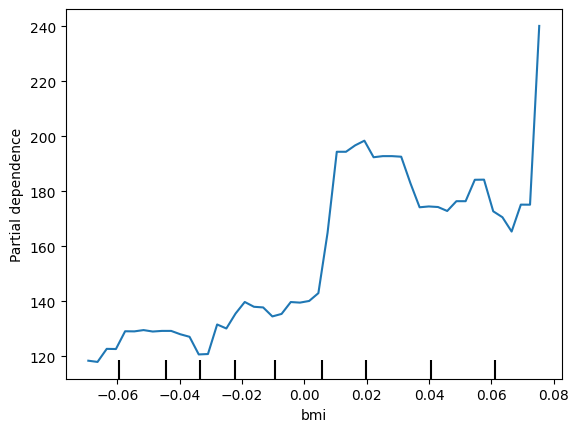

In [10]:
# Partial Dependence Plot (PDP) for 'bmi'
features = ['bmi']  # Only focusing on 'bmi'

# PDP using sklearn's PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(model, X_test, features, grid_resolution=50, kind='average')
plt.show()

# Build our own PDP for 'bmi'
feature_index = X.columns.get_loc('bmi')  # Get the index of 'bmi'
feature_values = np.linspace(np.min(X.iloc[:, feature_index]), np.max(X.iloc[:, feature_index]), num=80)
average_predictions = np.zeros_like(feature_values)

# Duplicate dataset and modify the 'bmi' feature values
X_modified = X.copy()

# Loop through 'bmi' values and calculate predictions
for i, value in enumerate(feature_values):
    X_modified.iloc[:, feature_index] = value
    predictions = model.predict(X_modified)
    average_predictions[i] = np.mean(predictions)

# Interpretation of the PDP

## 1. Shape of the Curve
This non-linear behavior suggests that the relationship between bmi and the predicted disease progression is complex, with varying levels of impact depending on the specific BMI value.

## 2. Increasing or Decreasing Values
The upward trend shows that higher BMI values generally lead to increased predicted disease progression, with sharp increases in certain ranges (e.g., between 0.0 and 0.04).

## 3. Plateau and Limits
There is no clear plateau; predictions continue to rise, suggesting that increasing BMI values strongly impact disease progression, especially at higher BMI levels.

## 4. Intuition and Context
The non-linear relationship aligns with medical knowledge that BMI affects disease risk, with sharper increases in progression at higher BMI values, emphasizing the importance of BMI management.



# Generating Individual Conditional Expectation (ICE) Plots
ICE plots show how each individual prediction changes when the bmi feature changes. This allows us to observe the variability in predictions for different instances.



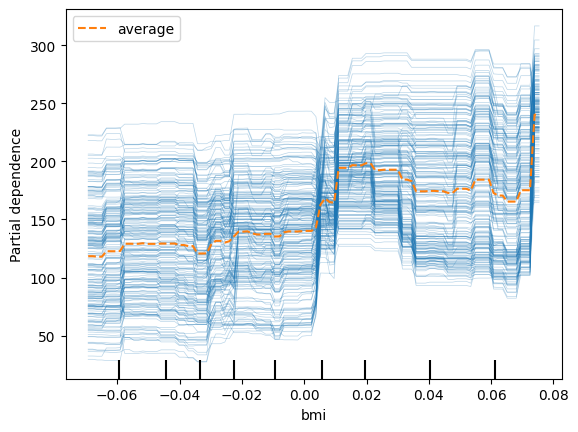

In [12]:
# ICE Plot for 'bmi' with PDP overlay
features = ['bmi']  # Focusing only on 'bmi'

# Create ICE plot (individual curves) with PDP (average) overlay
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='both')  # 'both' creates ICE + PDP
plt.show()

# Interpretation of the ICE Plot
**Individual Variability:** The ICE plot shows significant variation in how BMI impacts predictions for each instance, highlighting individual differences.

**General Trend:** Most lines follow the overall trend of increasing disease progression with higher BMI, but with varying slopes for different individuals.

**Non-linearity:** The plot reveals non-linear changes, with some individuals experiencing sharper increases in predictions at specific BMI values.

**Outliers:** Some lines deviate from the trend, suggesting that certain individuals are more or less sensitive to changes in BMI.

# Generating Accumulated Local Effects (ALE) Plots
ALE plots show how localized changes in bmi affect the prediction of disease progression.

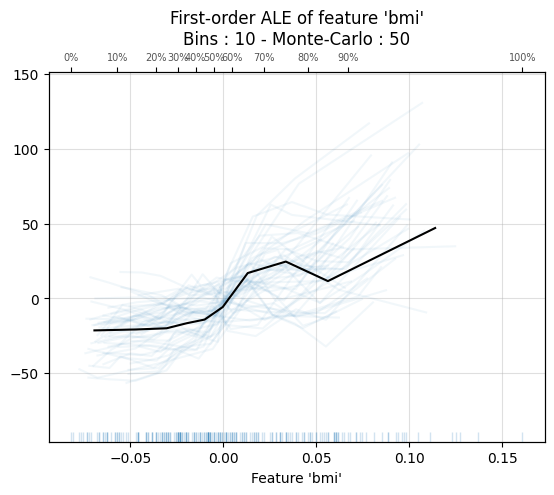

<Axes: title={'center': "First-order ALE of feature 'bmi'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'bmi'">

In [11]:
# Accumulated Local Effects (ALE) Plot for 'bmi'
ale_plot(model, X_train, 'bmi', monte_carlo=True)

# Interpretation of the ALE Plot


## 1. Axes Interpretation
X-axis: Represents the values of bmi, ranging from lower to higher BMI levels.

Y-axis: Shows the average effect of bmi on disease progression predictions, reflecting how changes in BMI influence the predicted outcome.
## 2. Curve Characteristics
The ALE plot reveals the local effects of bmi on predictions. The overall trend shows that as bmi increases, there is a positive effect on predicted disease progression.
## 3. Impact of the Curve
Steepness: There is a sharp upward slope between bmi values of around 0.00 and 0.05, indicating that increases in BMI within this range lead to significant changes in predictions.

Flat Regions: There is a flatter section after the peak at around 0.05, suggesting that further increases in BMI beyond this point have less impact on the model’s predictions.
## 4. Direction of the Curve
The upward slope of the curve confirms that higher BMI values are generally associated with higher predicted disease progression, aligning with the medical understanding that higher BMI can exacerbate health conditions.

No Downward Trend: Since there are no downward slopes in the graph, we can infer that increasing income does not lead to lower predicted prices, which aligns with typical housing market behavior.
## 5. Local Effects
Local Sensitivity: The steep sections of the curve emphasize where small increases in BMI result in large changes in predictions, indicating key thresholds where BMI significantly impacts disease progression.

Variance in Impact: Different segments of the curve suggest varying sensitivity to BMI changes, with a more pronounced effect at lower BMI values and diminishing returns at higher levels.


# Conclusion
This focused analysis on BMI using PDP, ICE, and ALE plots provides a clear understanding of how this feature influences disease progression in diabetes. The exploratory analysis shows moderate correlations between bmi and other features, and the plots reveal both the average trends and individual variations in the data.


# Summary of Key Findings
Correlation Analysis: Moderate positive correlation between bmi and other features, notably bp and s5, but no strong multicollinearity.

PDP: Shows a generally upward trend, indicating that higher BMI values lead to increased disease progression predictions.

ICE Plot: Displays variability in individual predictions, with some instances reacting more strongly to changes in BMI than others.

ALE Plot: Highlights local effects, showing that the impact of BMI is stronger at lower values and stabilizes at higher levels, identifying potential BMI thresholds that significantly influence predictions.